# Fitting other models to MICrONS 

Here we explore different fits to the MICrONS connectome using: 

1. Preferential attachment of A. L. Barabási and R. Albert “Emergence of scaling in random networks”, Science 286, pp 509-512, 1999.
2. An adaptation of the above adding directionality at random and adjusting for reciprocal connections
3. Small world model of Watts, Duncan J., and Steven H. Strogatz. "Collective dynamics of ‘small-world’networks." nature 393.6684 (1998): 440-442 
4. Directed preferential attachment of B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132–139, 2003.

Quick summary: 

- All models have siginficant higher order structure
- None of them fit simplex counts well across dimensions
- WS (#3) fits simplex counts best but by construction has very narrow degree distributions. 
- PA (#1, #2) fit the degree reasonably well, but not the shape of the simplex count function 
- PA (#3) doesn't fit so well the degree (using established heuristics), at least not without an involved 5-dimensional parameter scan. 
  
The best general fit is given by #2.  At the end of the notebok we generate 10 random instances of this type with the node positions of MICrONS.  The association of node and position is done totally at random, since none of the constructions use the node properties. 

In [1]:
import json
import numpy
import pandas
import conntility, connalysis
import scipy.sparse as sp
import networkx as nx
import math
from matplotlib import pyplot as plt


from pnagm import util




### Loding the MICrONS data set used in Figure 4

In [2]:
config_fn = "../configs/pnagm_L45E_microns_yscale_experimental_v1p5.json"

with open(config_fn, "r") as fid: # TODO add root 
    cfg = json.load(fid)

if "fn" in cfg["make_points"]:
    microns_fn = cfg["make_points"]["fn"]
    print("""
A reference connectome is expected at path {0},
          please place it there or update the path in the configuration file!
""".format(microns_fn))

pts, microns = util.points_from_microns(cfg["make_points"])



A reference connectome is expected at path microns_mm3_connectome_v1181.h5,
          please place it there or update the path in the configuration file!

12881


# Fitting preferential attachment PA model to microns data.

This is an undirected model, so we count undirected simplices 

In [3]:
# Compute undirected degrees when the undirected graph is represented by a symmetric matrix.
def undirected_deg(adj):
    return connalysis.network.topology.node_degree(adj)//2 

In [4]:
G = microns.matrix
G = (G+G.T).astype(bool) # symmetrizing to make undirected 
deg = undirected_deg(G)
sc={}
sc["microns"] = connalysis.network.topology.simplex_counts(G, simplex_type='undirected',)


In [5]:
# parameter scan to fit simplex counts. We fit around m = int(avg_degree / 2) which is what is requiered to aim to fit the mean degree.
sample_size = 10 
degs = {}
n = G.shape[0]
avg_degree = deg.mean() 
m_ranges = numpy.linspace(int(avg_degree / 2)//2, int(avg_degree / 2), num=sample_size, dtype=int)
for m in m_ranges:
    G_ctr = nx.adjacency_matrix(nx.barabasi_albert_graph(n, m))
    sc[f"PA control {m}"] = connalysis.network.topology.simplex_counts(G_ctr, simplex_type='undirected')
    degs[f"PA control {m}"] = undirected_deg(G_ctr)

df = pandas.concat([sc["microns"]]+[sc[f"PA control {m}"] for m in m_ranges], axis = 1, keys = ["microns"]+[f"PA control {m}" for m in m_ranges]).fillna(0)

Text(0.5, 0, 'Number of edges attached')

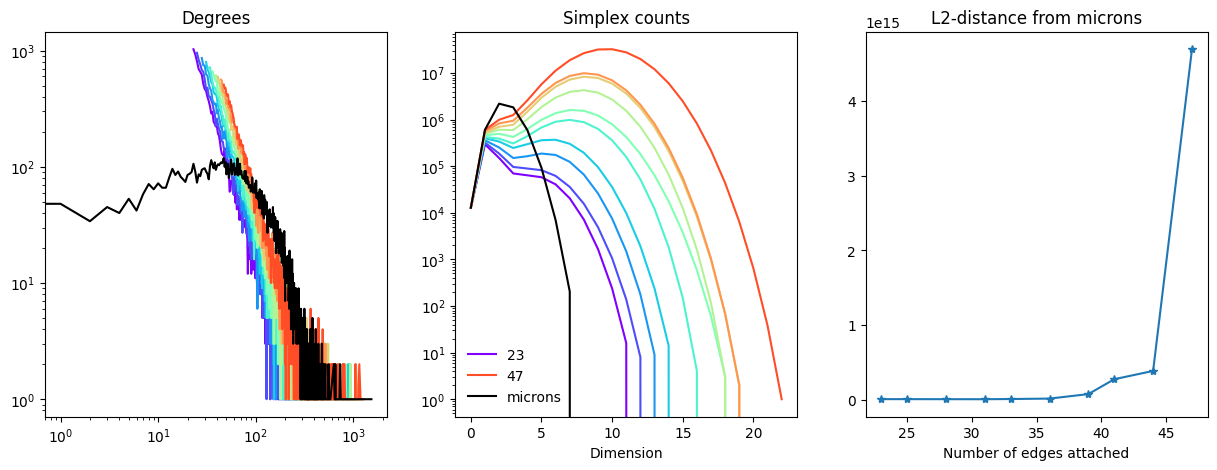

In [6]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
cmap = plt.get_cmap('rainbow')
colors = [cmap(i / (df.shape[1] - 1)) for i in range(df.shape[1] - 1)]

for i, col in enumerate(df.drop("microns", axis = 1).columns):
    m = int(col[11:])
    label = str(m) if m in [int(avg_degree / 2)//2, int(avg_degree / 2)] else None
    axs[0].plot(degs[col].value_counts().sort_index(), color = colors[i], label = label)
    axs[1].plot(df[col], color = colors[i], label = label)
axs[0].plot(deg.value_counts().sort_index(), color = "black", label = "microns")
axs[1].plot(df["microns"], color = "black", label = "microns")
axs[0].set_title("Degrees")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[1].set_title("Simplex counts")
axs[1].legend(frameon=False)
axs[1].set_xlabel("Dimension")

err = (df.drop("microns", axis = 1).sub(df["microns"], axis = 0)**2).sum(axis=0)
axs[2].plot(m_ranges, err, marker = "*")
axs[2].set_title("L2-distance from microns")
axs[2].set_xlabel("Number of edges attached")

In [7]:
n = G.shape[0]
col = err.idxmin()
m = int(col[11:])
#m = 47 #aqui aqui 
#col = 'PA control 47'
G_ctr = nx.adjacency_matrix(nx.barabasi_albert_graph(n, m))
sc["PA control"] = df[col]
degs["PA control"] = degs[col]

Text(0.5, 1.0, 'Simplex counts')

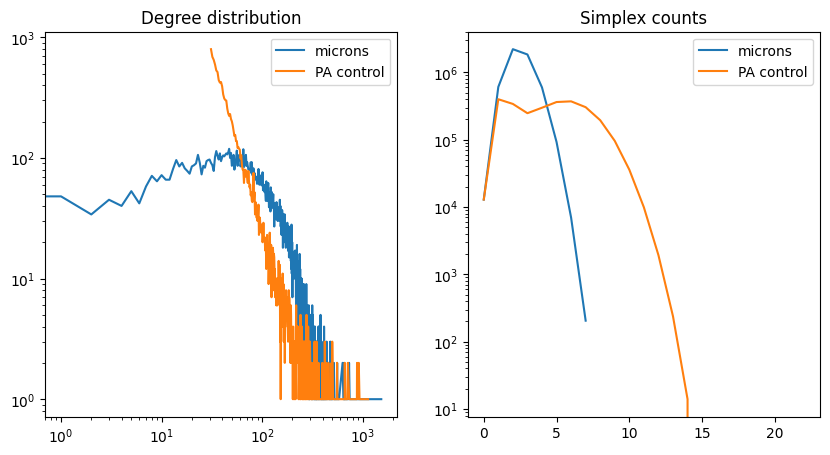

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].plot(deg.value_counts().sort_index(), label = "microns")
axs[0].plot(degs["PA control"].value_counts().sort_index(), label = "PA control")
axs[0].legend()
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_title("Degree distribution")

axs[1].plot(sc["microns"], label = "microns")
axs[1].plot(sc["PA control"], label = "PA control")
axs[1].legend()
#axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_title("Simplex counts")


### Adding direction at random 

In [9]:
def build_directed_from_symmetric(G_ctr, percent_top, random_state=None):
    # Build a directed graph from an undirected graph by adding directions at random 
    # percent_top is the percentage of the indices that are set in the upper triangular part of the matrix 
    # setting percent_top = 100, would heuristically maximize the number of simplices as all edges are consistently oriented
    # following the ordering of the nodes 
    
    assert numpy.abs(G_ctr-G_ctr.T).sum()==0, "G_ctr must be a symmetric"
    rng = numpy.random.default_rng(random_state)
    
    # Get upper triangular non-zero indices
    G_ctr = sp.coo_matrix(G_ctr)
    mask = G_ctr.row < G_ctr.col
    row_u = G_ctr.row[mask]
    col_u = G_ctr.col[mask]
    data_u = G_ctr.data[mask]
    
    n = len(data_u)
    n_upper = int(numpy.round(percent_top / 100 * n))
    
    indices = numpy.arange(n)
    rng.shuffle(indices)
    
    upper_idx = indices[:n_upper]
    lower_idx = indices[n_upper:]
    
    # Build directed matrix
    rows = numpy.concatenate([row_u[upper_idx], col_u[lower_idx]])
    cols = numpy.concatenate([col_u[upper_idx], row_u[lower_idx]])
    data = numpy.concatenate([data_u[upper_idx], data_u[lower_idx]])
    
    G_dir = sp.coo_matrix((data, (rows, cols)), shape=G_ctr.shape)
    return G_dir

def adjust_rc(adj, rc_per):
    adj = adj.tocoo()
    rc_add = int(adj.nnz*rc_per/(1-rc_per/2)/2) # number of reciprocal pairs, number of edges to add in opposite direction
    id_sel = numpy.sort(numpy.random.choice(len(adj.data), size = rc_add, replace = False)) # selected indices
    rows = numpy.concatenate([adj.row, adj.col[id_sel]])
    cols = numpy.concatenate([adj.col, adj.row[id_sel]])
    data = numpy.concatenate([adj.data, adj.data[id_sel]])
    
    return sp.coo_matrix((data, (rows, cols)), shape=adj.shape).tocsr()
def generate_PA_random_dir(n, m, percent_top, rc_per, random_state = None):
    # Generate undirected control
    G_ctr = nx.adjacency_matrix(nx.barabasi_albert_graph(n, m))
    # Add direction at random
    G_dir_oriented = build_directed_from_symmetric(G_ctr, percent_top=percent_top, random_state=random_state)
    # Add rc's at random 
    G_dir = adjust_rc(G_dir_oriented, rc_per)
    return G_dir
# scan and aggreagate parameters 
def scan_params(m_range, percent_top_range, n, rc_per, return_graph = False):
    sc_dict, degs_dict = {}, {}
    for m in m_range: 
        for percent_top in percent_top_range:
            G_dir = generate_PA_random_dir(n, m, percent_top, rc_per)
            degs_dict[f"m_{m}, per_top_{percent_top}"] = connalysis.network.topology.node_degree(G_dir, direction = ("IN", "OUT"))
            sc_dict[f"m_{m}, per_top_{percent_top}"] = connalysis.network.topology.simplex_counts(G_dir, simplex_type='directed')
    if return_graph: 
        return sc_dict, degs_dict, G_dir
    else: 
        return sc_dict, degs_dict



In [10]:
G = microns.matrix
sc, degs ={}, {}
sc["microns"] = connalysis.network.topology.simplex_counts(G, simplex_type='directed',)
degs["microns"] = connalysis.network.topology.node_degree(G, direction = ("IN", "OUT"))

In [11]:
# Set parameters 
n = G.shape[0]
avg_degree = deg.mean() 
m = int(avg_degree  / 2)# Closest total - degree match 
rc_per = connalysis.network.topology.rc_submatrix(G).nnz/G.nnz # reciprocity percentage matching original
m_range_choice = numpy.linspace(int(avg_degree/ 2), int(avg_degree *1.5 / 2), 10, dtype=int)
percent_top_range_choice = numpy.linspace(100, 50, 11)

# Scan across orientations and connection prob 
DFs = {}
for i, scan in enumerate(["connections", "directionality"]):
    if i == 0: 
        m_range = m_range_choice
        percent_top_range = [50]
    elif i ==1:
        percent_top_range = percent_top_range_choice
        m_range = [int(avg_degree/ 2)] # Best fit for total degree

    sc_dict, degs_dict = scan_params(m_range, percent_top_range, n, rc_per)

    # Aggregate in data frame 
    df_1 = pandas.concat([sc["microns"]]+[sc_dict[f"m_{m}, per_top_{p}"]for p in percent_top_range for m in m_range], 
                    axis = 1, keys = ["microns"]+[f"m_{m}, per_top_{p}" for p in percent_top_range for m in m_range]).fillna(0)
    df_2 ={}
    for direction in ["IN", "OUT"]:
        df_2[direction] = pandas.concat([degs["microns"][direction]]+[degs_dict[f"m_{m}, per_top_{p}"][direction]for p in percent_top_range for m in m_range], 
                                        axis = 1, keys = ["microns"]+[f"m_{m}, per_top_{p}" for p in percent_top_range for m in m_range]).fillna(0)

    DFs[scan]=[df_1, df_2]

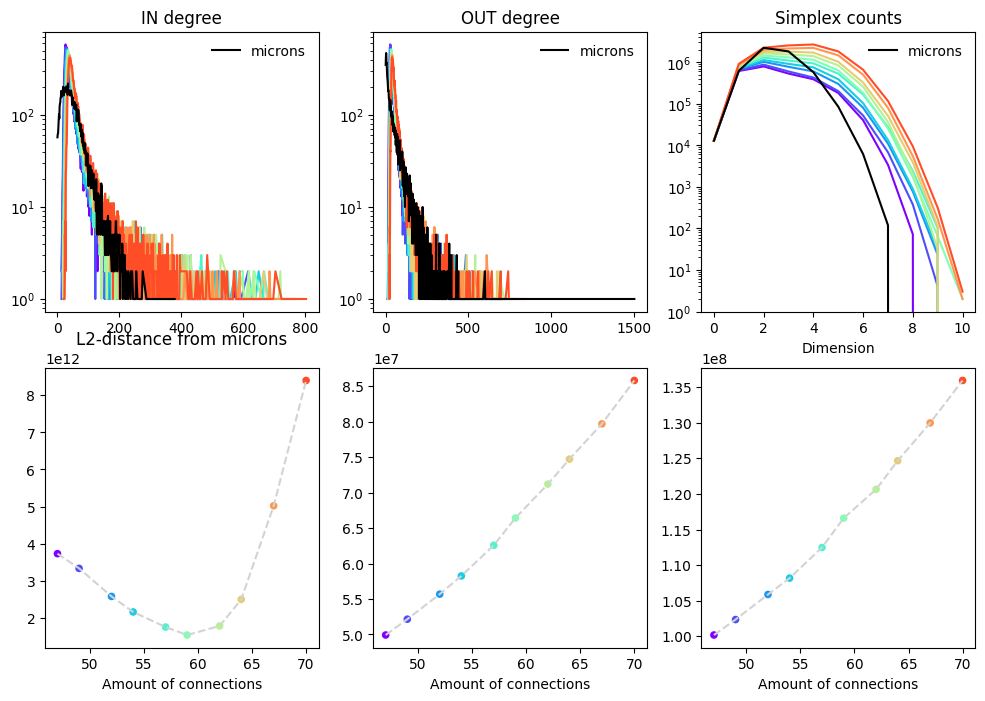

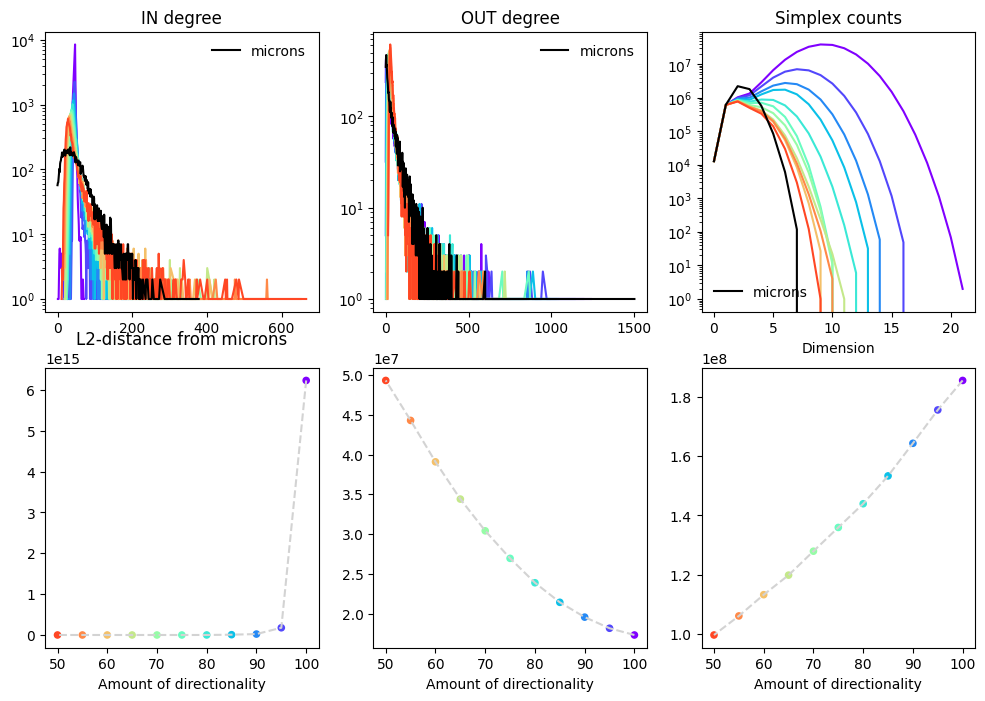

In [12]:
# Scanning across parameters 

for scan in DFs.keys():
    df_sc, df_degs = DFs[scan]
    title = f"{scan} scan"
    scan_range = m_range_choice if scan == "connections" else percent_top_range_choice

    #Make Figure 
    fig, axs = plt.subplots(2,3, figsize=(12, 8))
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i / (df_sc.shape[1] - 1)) for i in range(df_sc.shape[1] - 1)]

    for k, direction in enumerate(["IN", "OUT"]):
        for i, col in enumerate(df_degs[direction].drop("microns", axis = 1).columns):
            #p = int(float(col[23:]))
            #label = str(p) if p in [0.5, 0.6] else None
            axs[0, k].plot(df_degs[direction][col].value_counts().sort_index(), color = colors[i])
        axs[0, k].plot(df_degs[direction]["microns"].value_counts().sort_index(), color = "black", label = "microns")
        axs[0, k].set_title(f"{direction} degree")
        axs[0, k].legend(frameon=False)
        #axs[0, k].set_xscale("log")
        axs[0, k].set_yscale("log")


    for i, col in enumerate(df_sc.drop("microns", axis = 1).columns):
        #p = int(float(col[23:]))
        #label = str(p) if p in [0.5, 0.6] else None
        axs[0, 2].plot(df_sc[col], color = colors[i])
    axs[0, 2].plot(df_sc["microns"], color = "black", label = "microns")
    axs[0, 2].set_title("Simplex counts")
    axs[0, 2].legend(frameon=False)
    axs[0, 2].set_xlabel("Dimension")
    axs[0, 2].set_yscale("log")

    for (k, df) in zip([0, 1, 2], [df_sc, df_degs["IN"], df_degs["OUT"]]): 
        err = (df.drop("microns", axis = 1).sub(df["microns"], axis = 0)**2).sum(axis=0)
        axs[1,k].plot(scan_range, err, color = "lightgray", linestyle="dashed")
        axs[1,k].scatter(scan_range, err, marker = "o", color = colors, s=20)
        axs[1,k].set_xlabel(f"Amount of {scan}")
    axs[1,0].set_title("L2-distance from microns")


# Fitting scale free model

In [13]:
# parameter scan to fit simplex counts

p_ranges = numpy.linspace(0.5, 0.6, 30)
k = int(avg_degree)
for p in p_ranges:
    G_ctr = nx.adjacency_matrix(nx.watts_strogatz_graph(n, k, p))
    sc[f"WS control {p}"] = connalysis.network.topology.simplex_counts(G_ctr, simplex_type='undirected')

df = pandas.concat([sc["microns"]]+[sc[f"WS control {p}"] for p in p_ranges], axis = 1, keys = ["microns"]+[f"WS control {p}" for p in p_ranges]).fillna(0)

Text(0.5, 0, 'Amount of rewiring (p)')

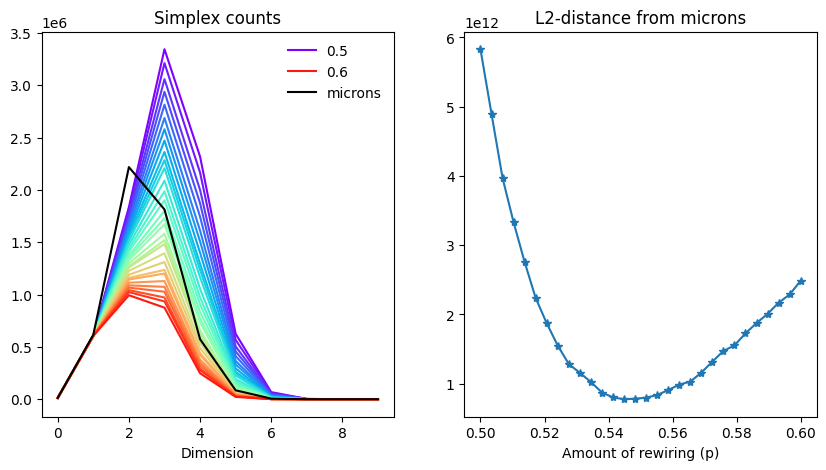

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
cmap = plt.get_cmap('rainbow')
colors = [cmap(i / (df.shape[1] - 1)) for i in range(df.shape[1] - 1)]

for i, col in enumerate(df.drop("microns", axis = 1).columns):
    p = float(col[11:])
    label = str(p) if p in [0.5, 0.6] else None
    axs[0].plot(df[col], color = colors[i], label = label)
axs[0].plot(df["microns"], color = "black", label = "microns")
axs[0].set_title("Simplex counts")
axs[0].legend(frameon=False)
axs[0].set_xlabel("Dimension")

err = (df.drop("microns", axis = 1).sub(df["microns"], axis = 0)**2).sum(axis=0)
axs[1].plot(p_ranges, err, marker = "*")
axs[1].set_title("L2-distance from microns")
axs[1].set_xlabel("Amount of rewiring (p)")


Text(0.5, 1.0, 'Simplex counts')

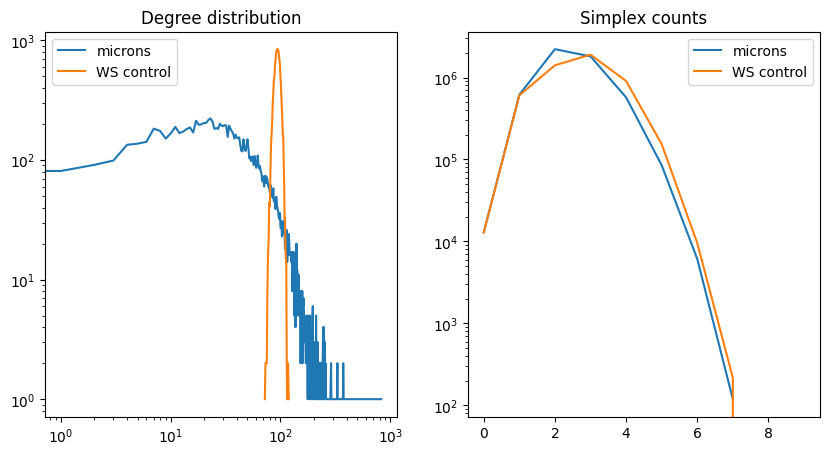

In [15]:
n = G.shape[0]
k = math.ceil(deg.mean()/2-1)*2 # round down mean degree to nearest even number
col = err.idxmin()
p = float(col[11:])
G_ctr = nx.adjacency_matrix(nx.watts_strogatz_graph(n, k, p))
sc["WS control"] = df[col]

fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].plot(undirected_deg(G).value_counts().sort_index(), label = "microns")
axs[0].plot(undirected_deg(G_ctr).value_counts().sort_index(), label = "WS control")
axs[0].legend()
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_title("Degree distribution")

axs[1].plot(sc["microns"], label = "microns")
axs[1].plot(sc["WS control"], label = "WS control")
axs[1].legend()
#axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_title("Simplex counts")

# Fitting preferential attachment directed 

In [16]:
G = microns.matrix
sc, degs ={}, {}
sc["microns"] = connalysis.network.topology.simplex_counts(G, simplex_type='directed',)
degs["microns"] = connalysis.network.topology.node_degree(G, direction = ("IN", "OUT"))

In [17]:
n=G.shape[0]
initial_graph = None
beta = 1 - 1/(degs["microns"].sum(axis=1).mean()+1) # from heuristic of degree distribution
delta_in=0.2 # default
delta_out=0.2 # symetrizing default
number_of_samples = 10 
alpha_frac_range = numpy.linspace(0.9,0.1, number_of_samples)

for alpha_frac in alpha_frac_range:
    print(alpha_frac)
    alpha = (1-beta)*alpha_frac
    gamma = 1-beta-alpha
    assert alpha+beta+gamma == 1
    G_ctr = nx.adjacency_matrix(nx.scale_free_graph(n, alpha = alpha, beta = beta, gamma = gamma, 
                                                    delta_in=delta_in, delta_out=delta_out, 
                                                     initial_graph=initial_graph ))
    G_ctr.setdiag(0)
    degs[f"PA_dir_{alpha_frac}"] = connalysis.network.topology.node_degree(G_ctr, direction = ("IN", "OUT"))
    sc[f"PA_dir_{alpha_frac}"] = connalysis.network.topology.simplex_counts(G_ctr, simplex_type='directed',)


0.9
0.8111111111111111
0.7222222222222222
0.6333333333333333
0.5444444444444445
0.45555555555555555
0.3666666666666667
0.2777777777777778
0.18888888888888888
0.1


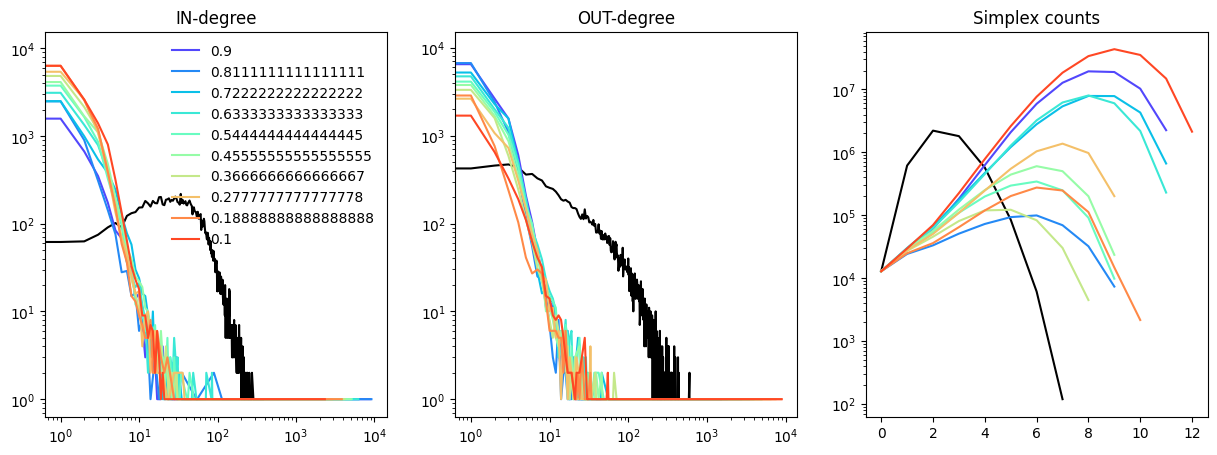

In [18]:
colors = [cmap(i / (len(degs.keys()))) for i in range(len(degs.keys()))]

fig, axs = plt.subplots(1,3, figsize = (15,5)) 
for i, direction in enumerate(degs["microns"].columns):
    for j, key in enumerate(degs.keys()):
        color = "black" if key == "microns" else colors[j]
        axs[i].plot(degs[key][direction].value_counts().sort_index(), label = key[7:], color = color)
        axs[i].set_title(f"{direction}-degree")
        axs[i].set_yscale("log")
        axs[i].set_xscale("log")

for j, key in enumerate(degs.keys()):
    color = "black" if key == "microns" else colors[j]
    axs[2].plot(sc[key], label = key, color = color)
axs[2].set_title(f"Simplex counts")
axs[2].set_yscale("log")
axs[0].legend(frameon=False)


# Final choice generate instances

In [19]:
root_out = "/Users/danielaegas/Library/CloudStorage/OneDrive-OpenBrainInstitute/Shared Documents - OBI - Scientific staff/Data/microns_PA_fits"
path_out = f"{root_out}/microns_PA_instance.h5"

# Reinitializng for plotting
sc = {"microns": sc["microns"]}
degs = {"microns": degs["microns"]}

# Chosen parameters 
chosen_per = 50.0 # orient edges totally at random
chosen_m = int(avg_degree/ 2) # best parameter to fit the mean total degree

for i in range(10): 
    temp1, temp2, G_dir = scan_params([chosen_m], [chosen_per], n, rc_per, return_graph = True)
    sc[i] = temp1[f'm_{chosen_m}, per_top_{chosen_per}']
    degs[i] = temp2[f'm_{chosen_m}, per_top_{chosen_per}']
    M = conntility.ConnectivityMatrix(G_dir, vertex_properties=microns.vertices.set_index("index"))
    M.to_h5(path_out, group_name=f"instance_{i}")

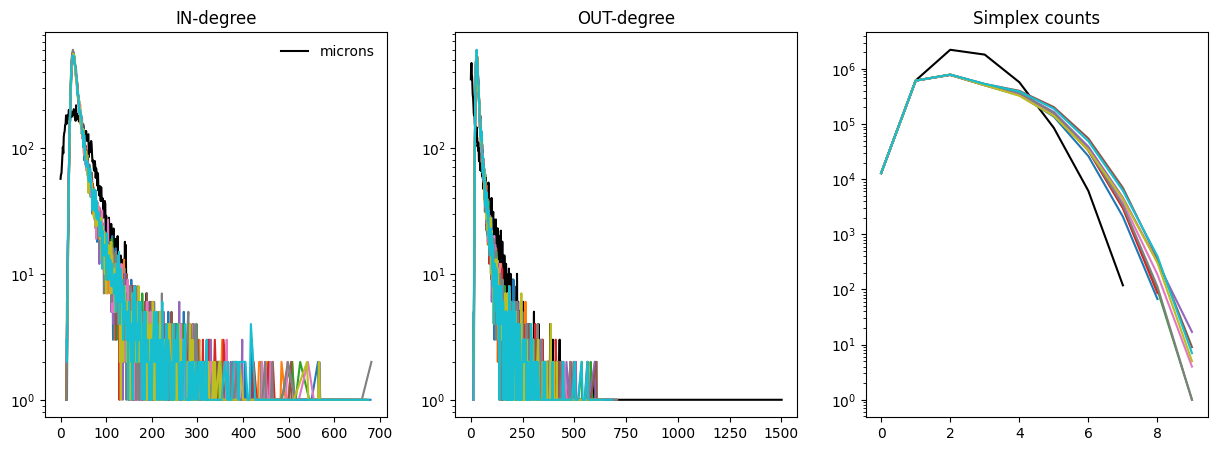

In [20]:
fig, axs = plt.subplots(1,3, figsize = (15,5)) 
for i, direction in enumerate(degs["microns"].columns):
    for key in sc.keys():
        color = "black" if key == "microns" else None
        label = key if key == "microns" else None
        axs[i].plot(degs[key][direction].value_counts().sort_index(), label = label, color = color)
        axs[i].set_title(f"{direction}-degree")
        axs[i].set_yscale("log")
        #axs[i].set_xscale("log")

for key in sc.keys():
    color = "black" if key == "microns" else None
    axs[2].plot(sc[key], color = color)
axs[2].set_title(f"Simplex counts")
axs[2].set_yscale("log")
axs[0].legend(frameon=False)